# This notebook is for a Bruker 2PPlus operated by PrairieView software 5.7 (5.7.64.300), Update 2 Final

## Ensure the lights are turned off, or the blinds are closed to not expose PMTs to high light levels
## This is for repeated measurements over a long period of time (years) using tritium and phosphor samples
## Each measurement scans all of the voltage levels of the PMTs for all PMT channels, in this instance it is 4 PMTs from 0-900 gain (GaAsP specific)
## An image is acquired at each gain and the average intensity of all of the 512x512 pixels is taken to give a reading for that gain
## This is saved in a numpy file for plotting/tracking over time

In [54]:
import win32com.client
from datetime import date
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook

In [55]:
### set folder here

# construct Packer-xkcd-compliant datestring
datestring = date.today().isoformat()

# folder = r"F:\Data\{0}\{1}\PowerMeasurements".format(name, datestring)
folder = r"C:\PMTSensitivity\{0}".format(datestring)

if not os.path.exists(folder):
    os.makedirs(folder)
    
folder

'C:\\PMTSensitivity\\2023-02-03'

In [56]:
# Start PrairieLink
pl = win32com.client.Dispatch('PrairieLink.Application')
print('object created')

# Connect to Client
pl.Connect()
print(pl.Connected())

object created
True


In [58]:
# setup PV for control background reading
# imaging shutter open, pmt shutters automatic

pl.SendScriptCommands('-fa 1')
pl.SendScriptCommands('-fi Singlescan 1')
pl.SendScriptCommands('-is 512')
pl.SendScriptCommands('-sts resonantMultiSamplingEnabled False') #this must be enabled to ensure the output is consistent with manual acquisition
pl.SendScriptCommands('-sts automaticallyConvertRawFiles AfterAcquisition')
pl.SendScriptCommands('-lp Imaging 3')
pl.SendScriptCommands('-p ' + folder)

True

In [121]:
acq_type = 'red_sample' # control, red_sample or green_sample

channels = [1,2,3,4]
pmt_gains = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

for channel in channels:
    pl.SendScriptCommands(f'-sts pmtGain 0 "PMT {channel} HV"')
    pl.SendScriptCommands(f'-c {channel} Off')

image_stack = np.zeros([4, 10, 512, 512])

for channel in channels: 
    
    pl.SendScriptCommands('-fi Singlescan 1')
    pl.SendScriptCommands(f'-c {channel} On')
    
    for gain_idx, pmt_gain in enumerate(pmt_gains):
        
        pl.SendScriptCommands(f'-fn Singlescan PMT{channel}_{acq_type} addDateTime')
        pl.SendScriptCommands(f'-ss')
        pl.SendScriptCommands(f'-sts pmtGain {pmt_gain} "PMT {channel} HV"')
        
        image_stack[channel-1, gain_idx] = pl.GetImage(channel)
        
    pl.SendScriptCommands(f'-sts pmtGain 0 "PMT {channel} HV"')
        
    pl.SendScriptCommands(f'-c {channel} Off')

PMT_mean = image_stack.mean(axis=(2,3))

<IPython.core.display.Javascript object>


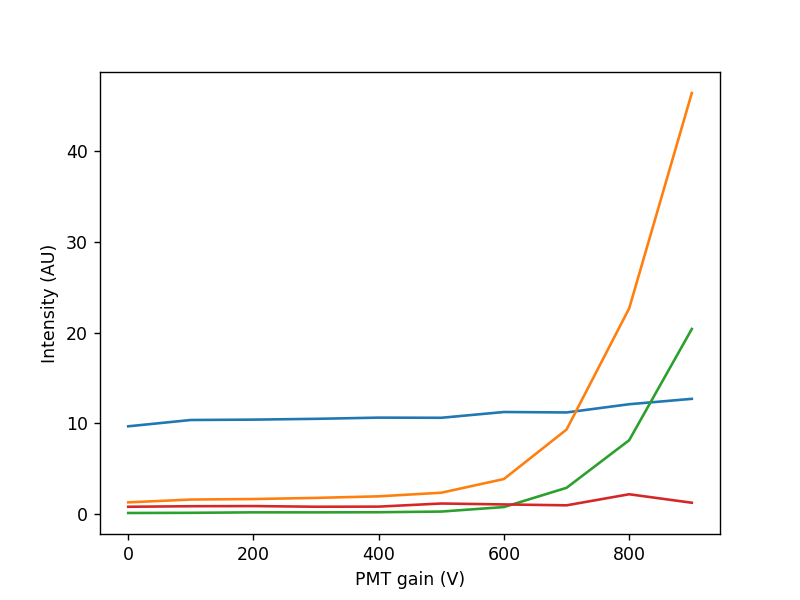

In [122]:
plt.plot(np.array(pmt_gains)-100, PMT_mean.T);
plt.xlabel('PMT gain (V)');
plt.ylabel('Intensity (AU)');
np.save(os.path.join(folder + '\PMT_' + acq_type + '_mean_values_{0}'.format(datestring)), PMT_mean)

In [128]:
channel = 2 #start at 1, not 0

parent_folder = os.path.dirname(folder)

num_dates = len(os.listdir(parent_folder))
grouped_means = np.empty([num_dates, 10])

i = 0

for root, dirs, files in os.walk(parent_folder):
    for file in files:
        if all(s in file for s in ['.npy', acq_type]):
            print(file)
            single_mean = np.load(os.path.join(root, file))[channel-1]
            grouped_means[i] = single_mean
            i += 1

PMT_red_sample_mean_values_2023-02-03.npy
